## Marker

In [1]:
import os, glob, pathlib, json, time, re
from typing import List, Dict, Any, Optional, TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.chat_models import ChatDeepInfra
import os
from dotenv import load_dotenv
load_dotenv()

# LLMs
GEN_MODEL = os.getenv('GEN_MODEL')
EMBED_MODEL = os.getenv('EMBED_MODEL')
DEEPINFRA_API_KEY = os.getenv('DEEPINFRA_API_KEY')

llm_gen = ChatDeepInfra(
    model=GEN_MODEL,              
    temperature=0,
    max_tokens=1024,
    # streaming=True,              # optional
)

from langchain_community.embeddings import DeepInfraEmbeddings

# for dense vectors (will create sparse vector later)
embeddings = DeepInfraEmbeddings(
    model_id=EMBED_MODEL,          
    deepinfra_api_token=DEEPINFRA_API_KEY,
    query_instruction="",
    embed_instruction="",
    normalize=True,                 # cosine similarity friendly
)


# Paths
DATA_DIR = "sample_documents/PDFs"     # drop PDFs here
TMP_DIR  = "sample_documents/PDFs_parsed"   # Marker markdown output
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
pathlib.Path(TMP_DIR).mkdir(parents=True, exist_ok=True)


## API's
from dotenv import load_dotenv
load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
pinecone_api_key = os.getenv("PINECONE_API_KEY")
cohere_api_key = os.getenv("COHERE_API_KEY")


# ============================================
# PDF parsing with Marker -> Markdown
# ============================================

from marker.converters.pdf import PdfConverter
from marker.models import create_model_dict
from marker.output import text_from_rendered

def marker_parse(pdf_path: str) -> str:
    converter = PdfConverter(artifact_dict=create_model_dict())
    rendered = converter(pdf_path)
        
    # 1. We will return the pure markdown only 
    # 2. The images in our sample documents (pdf) has no meaning so we will not include images in our return 
    # 3. In this specific example the metadata we have is almost useless for a RAG system
    md, meta, images = text_from_rendered(rendered)
    return md
    

def parse_folder_to_md(input_dir: str, out_dir: str) -> List[Dict[str, str]]:
    out = []
    for pdf in glob.glob(str(pathlib.Path(input_dir) / "**/*.pdf"), recursive=True):
        md = marker_parse(pdf)
        stem = pathlib.Path(pdf).stem
        md_path = str(pathlib.Path(out_dir) / f"{stem}.md")
        with open(md_path, "w", encoding="utf-8") as f:
            f.write(md)
        out.append({"source_pdf": pdf, "markdown_path": md_path})
    return out

e:\0_AI_2025\railway\rag_082025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parsed = parse_folder_to_md(DATA_DIR, TMP_DIR)
print(f"Parsed PDFs: {len(parsed)}")

Recognizing Text: 100%|██████████| 17/17 [01:26<00:00,  5.08s/it]
Detecting bboxes: 0it [00:00, ?it/s]
Recognizing Text: 100%|██████████| 17/17 [01:24<00:00,  4.97s/it]
Detecting bboxes: 0it [00:00, ?it/s]


Parsed PDFs: 2


In [3]:
# preview (list of dict)
parsed

[{'source_pdf': 'sample_documents\\PDFs\\Philippines Flood Control Corruption_39767746-b609-45a8-84de-d600f8ba3cff.pdf',
  'markdown_path': 'sample_documents\\PDFs_parsed\\Philippines Flood Control Corruption_39767746-b609-45a8-84de-d600f8ba3cff.md'},
 {'source_pdf': 'sample_documents\\PDFs\\Philippines Flood Control Corruption_46371b3e-e694-4017-95fa-e3f689803067.pdf',
  'markdown_path': 'sample_documents\\PDFs_parsed\\Philippines Flood Control Corruption_46371b3e-e694-4017-95fa-e3f689803067.md'}]

## Transform to Langchain Documents Structure

In [4]:
# ============================================
# Build Documents 
# ============================================
from langchain_core.documents import Document

# list of documents (wraped in langchain Document)
docs: List[Document] = []

# Read the Markdown file
for item in parsed:
    with open(item["markdown_path"], "r", encoding="utf-8") as f:
        text = f.read()

    docs.append(Document(page_content=text, 
                         metadata={"source": item["source_pdf"], "md": item["markdown_path"]}))
    

# preview
docs

[Document(metadata={'source': 'sample_documents\\PDFs\\Philippines Flood Control Corruption_39767746-b609-45a8-84de-d600f8ba3cff.pdf', 'md': 'sample_documents\\PDFs_parsed\\Philippines Flood Control Corruption_39767746-b609-45a8-84de-d600f8ba3cff.md'}, page_content='# **Philippines Flood Control Corruptio[n](https://medium.com/plans?dimension=post_audio_button&postId=3e3ce980dfa0&source=upgrade_membership---post_audio_button-----------------------------------------)**\n\nMany Filipinos are not deeply familiar with the law, and as a result, many simply speculate based on whatever information is fed to them. But what is the truth behind all the Senate and House investigations that are showcased in public? These two chambers often have different views and, at times, conflicting interests.\n\nThis article only reflects my point of view. My goal is to explain what is happening and why.\n\n### **The Discaya Revelations**\n\n**On September 1, 2025,** the first Blue Ribbon hearing ended with s

## Chunking
Chunking means breaking a document into smaller parts before creating embeddings, so the system can search and understand them better.

### Langchain RecursiveCharacterTextSplitter
> This is my preffered chunking based on our document structure

In [5]:
import tiktoken
from langchain_text_splitters import RecursiveCharacterTextSplitter

encoding = tiktoken.get_encoding("cl100k_base")

splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name=encoding.name,  
    chunk_size=400,
    chunk_overlap=0,
    separators=[
        "\n```",                    # keep fenced code blocks intact
        "\n# ",                     # H1
        "\n## ",                    # H2
        "\n### ",                   # H3
        "\n#### ",                  # H4
    
        "\n\n",                     # paragraphs
        "\n- ", "\n* ", "\n1. ",    # lists
        "\n|",                      # table row starts (helps keep rows together)
        "\n",                       # line breaks
        ". ",                       # sentence-ish
        " ",
        ""
    ],
)

In [6]:
chunks: List[Document] = splitter.split_documents(docs)
print("Total chunks:", len(chunks))
chunks

Total chunks: 16


[Document(metadata={'source': 'sample_documents\\PDFs\\Philippines Flood Control Corruption_39767746-b609-45a8-84de-d600f8ba3cff.pdf', 'md': 'sample_documents\\PDFs_parsed\\Philippines Flood Control Corruption_39767746-b609-45a8-84de-d600f8ba3cff.md'}, page_content='# **Philippines Flood Control Corruptio[n](https://medium.com/plans?dimension=post_audio_button&postId=3e3ce980dfa0&source=upgrade_membership---post_audio_button-----------------------------------------)**\n\nMany Filipinos are not deeply familiar with the law, and as a result, many simply speculate based on whatever information is fed to them. But what is the truth behind all the Senate and House investigations that are showcased in public? These two chambers often have different views and, at times, conflicting interests.\n\nThis article only reflects my point of view. My goal is to explain what is happening and why.'),
 Document(metadata={'source': 'sample_documents\\PDFs\\Philippines Flood Control Corruption_39767746-b6

In [9]:
# Langchain_chunker = [chunk.page_content for chunk in chunks]
# analyze_chunks_df(Langchain_chunker, use_tokens=True).head(3)

## Pinecone Ingestion (dense & sparse)

**Setup**

In [10]:
# ============================================
# Pinecone (hybrid index) setup
# ============================================
from pinecone import Pinecone, ServerlessSpec

# Pinecone config
INDEX_NAME = "rag-hybrid-agentic"
PC_CLOUD = "aws"
PC_REGION = "us-east-1"     # where serverless is available

pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])
existing = {ix["name"]: ix for ix in pc.list_indexes()}
if INDEX_NAME not in existing:
    pc.create_index(
        name=INDEX_NAME,
        dimension=1024,         # text-embedding-3-large
        metric="dotproduct",    # supports sparse+dense hybrid
        spec=ServerlessSpec(cloud=PC_CLOUD, region=PC_REGION),
    )
index = pc.Index(INDEX_NAME)

In [11]:
# ============================================
# 4) Embeddings + BM25 sparse encoder
# ============================================
from pinecone_text.sparse import BM25Encoder


# 1. embeding
# embeddings (already done earlier)

# 2. sparse
texts = [d.page_content for d in chunks]
bm25 = BM25Encoder()
bm25.fit(texts)

# (Optional) persist & reload if you want to reuse in a fresh process
bm25_path = "./bm25_values.json" 
bm25.dump("bm25_values.json")


100%|██████████| 16/16 [00:00<00:00, 273.09it/s]


In [12]:
dense_vecs = embeddings.embed_documents(texts)           # list[list[float]]
sparse_vecs = bm25.encode_documents(texts)               # list[{"indices":[...], "values":[...]}]

In [13]:
import hashlib
from tqdm import tqdm

# IDs are deterministic, so re-running safely overwrites (idempotent upsert).
def make_id(doc):
    # stable id from content + common metadata fields
    base = f"{doc.metadata.get('source','')}|{doc.metadata.get('md','')}|{doc.page_content}"
    return hashlib.sha256(base.encode("utf-8")).hexdigest()[:32]

In [14]:
to_upsert = []
for doc, dense, sparse in tqdm(zip(chunks,
                                   dense_vecs, 
                                   sparse_vecs), 
                                   total=len(chunks)):
    metadata = {
        **doc.metadata,
        "context": doc.page_content,  # IMPORTANT: retriever expects "context"
    }
    to_upsert.append({
        "id": doc.metadata.get("id") or make_id(doc),
        "values": dense,
        "sparse_values": sparse,      # {"indices":[...], "values":[...]}
        "metadata": metadata,
    })

100%|██████████| 16/16 [00:00<00:00, 16412.05it/s]


**Upsert to Pinecone**

In [15]:
# -------------------------------
# Upsert to Pinecone (batch)
# -------------------------------
namespace = "docs"
batch = 4
for i in range(0, len(to_upsert), batch):
    index.upsert(vectors=to_upsert[i:i+batch], namespace=namespace)

# RETRIEVER

## Hybrid Retriever | Query Testing

In [16]:
# -------------------------------
# Create the hybrid retriever
# -------------------------------
from langchain_community.retrievers import PineconeHybridSearchRetriever

retriever = PineconeHybridSearchRetriever(
    embeddings=embeddings, #(dense)
    sparse_encoder=bm25,
    index=index,
    namespace=namespace,
    alpha=0.7,     # 0=sparse only, 1=dense only. Tune.
    top_k=6
)

In [17]:
# -------------------------------
# Query the top k docs
# -------------------------------
query = '''Who was help in contempt in the senate?'''

docs = retriever.invoke(query)

for d in docs:
    print(d.page_content[:60].replace("\n", " "), "… | source:", d.metadata.get("source"))

### **— This is during the Senate hearing held prior to the  … | source: E:\0_AI_2025\railway\rag_082025\sample_documents\PDFs\Philippines Flood Control Corruption_39767746-b609-45a8-84de-d600f8ba3cff.pdf
### **— This is during the Senate hearing held prior to the  … | source: E:\0_AI_2025\railway\rag_082025\sample_documents\PDFs\Philippines Flood Control Corruption_46371b3e-e694-4017-95fa-e3f689803067.pdf
### **— This is during the Senate hearing held prior to the  … | source: E:\0_AI_2025\railway\rag_082025\sample_documents\PDFs\Philippines Flood Control Corruption_991ff679-373a-4904-b890-d519a80e720b.pdf
### **— This is during the Senate hearing held prior to the  … | source: E:\0_AI_2025\railway\rag_082025\sample_documents\PDFs\Philippines Flood Control Corruption_eef0fe38-1f13-4512-96c3-590827214254.pdf
The difference, as explained in hearings, was that **Alcanta … | source: E:\0_AI_2025\railway\rag_082025\sample_documents\PDFs\Philippines Flood Control Corruption_39767746-b609-45

# Re Rank

In [18]:
# ============================================
# 7) ReRanker (Cohere) and compression retriever
# ============================================
from langchain_cohere import CohereRerank
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever


compressor = CohereRerank(model="rerank-v3.5", top_n=4)
hybrid_rerank_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever,
)

**Testing Re rank**

In [19]:
# Test
def check_rank(docs, title):
    print(f"\n=== {title} ({len(docs)} docs) ===")
    for i, d in enumerate(docs, 1):
        score = d.metadata.get("relevance_score") or d.metadata.get("score")
        src   = d.metadata.get("source")
        preview = d.page_content.replace("\n", " ")[:140]
        print(f"{i:>2}. score={score} | {preview} | {src} ")

In [20]:
reranked_docs = hybrid_rerank_retriever.invoke(query)
check_rank(reranked_docs, "RERANKED top-k (Cohere)")


=== RERANKED top-k (Cohere) (4 docs) ===
 1. score=0.6102915 | ### **— This is during the Senate hearing held prior to the Congress hearing —** Hernandez gave weak responses, denied the evidence presente | sample_documents\PDFs\Philippines Flood Control Corruption_46371b3e-e694-4017-95fa-e3f689803067.pdf 
 2. score=0.6102915 | ### **— This is during the Senate hearing held prior to the Congress hearing —** Hernandez gave weak responses, denied the evidence presente | sample_documents\PDFs\Philippines Flood Control Corruption_39767746-b609-45a8-84de-d600f8ba3cff.pdf 
 3. score=0.6102915 | ### **— This is during the Senate hearing held prior to the Congress hearing —** Hernandez gave weak responses, denied the evidence presente | E:\0_AI_2025\railway\rag_082025\sample_documents\PDFs\Philippines Flood Control Corruption_46371b3e-e694-4017-95fa-e3f689803067.pdf 
 4. score=0.6102915 | ### **— This is during the Senate hearing held prior to the Congress hearing —** Hernandez gave weak respo

>Pinecone’s hybrid score is great for finding potentially relevant chunks; a reranker is for ordering them by how well they actually answer your specific query. Use reranking when the top-few need to be right.

In [21]:
query

'Who was help in contempt in the senate?'

In [22]:
hybrid_rerank_retriever.invoke(query)

[Document(metadata={'md': 'sample_documents\\PDFs_parsed\\Philippines Flood Control Corruption_46371b3e-e694-4017-95fa-e3f689803067.md', 'source': 'sample_documents\\PDFs\\Philippines Flood Control Corruption_46371b3e-e694-4017-95fa-e3f689803067.pdf', 'score': 0.515320241, 'relevance_score': 0.6102915}, page_content="### **— This is during the Senate hearing held prior to the Congress hearing —** Hernandez gave weak responses, denied the evidence presented, and failed to provide a valid explanation. As a result, he was cited in contempt of the Senate.\n\n**Important clarification:** Being cited in contempt is **not a criminal conviction**. It only means the Senate can detain a witness for refusing to cooperate or obstructing proceedings. Any actual criminal liability will still be decided by the **DOJ and the courts** after a full investigation.\n\nThe primary purpose of citing someone in contempt is to **compel them to testify, produce documents, or behave properly during a hearin**g.

# Test With LLM

In [23]:
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


# --- Prompt & chain wiring ---
SYSTEM_PROMPT = """You are a helpful assistant that answers using only the provided context.
If the answer is not in the context, say you don't know.
Cite sources as [source:<id or title>] inline where relevant."""

prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_PROMPT),
    ("human", "Question: {question}\n\nContext:\n{context}")
])

def format_docs(docs):
    # Keep the reranker’s order; include simple source handles for citations
    lines = []
    for i, d in enumerate(docs, 1):
        src = d.metadata.get("source") or d.metadata.get("id") or f"doc{i}"
        lines.append(f"[{src}] {d.page_content}")
    return "\n\n".join(lines)

# We’ll produce both the answer and the source docs in one go.
rag_inputs = RunnableParallel(
    context=hybrid_rerank_retriever | format_docs,
    docs=hybrid_rerank_retriever,     # pass through the actual Document objects too
    question=RunnablePassthrough()
)

chain = (
    rag_inputs
    | {"question": lambda x: x["question"], "context": lambda x: x["context"]}
    | prompt
    | llm_gen
    | StrOutputParser()
)


In [24]:
# --- Run it ---
user_query = "Who was held cited in contempt in the senate?"
answer_text = chain.invoke(user_query)

# If you want to surface human-friendly citations afterwards:
docs = rag_inputs.invoke(user_query)["docs"]
citations = [
    (d.metadata.get("relevance_score"),  d.page_content[:100])
    for i, d in enumerate(docs)
]

print(answer_text)
print("\nSources used (in reranked order):", citations)

Hernandez was cited in contempt of the Senate [source: Philippines Flood Control Corruption].

Sources used (in reranked order): [(0.8724455, '### **— This is during the Senate hearing held prior to the Congress hearing —** Hernandez gave weak'), (0.8724455, '### **— This is during the Senate hearing held prior to the Congress hearing —** Hernandez gave weak'), (0.8724455, '### **— This is during the Senate hearing held prior to the Congress hearing —** Hernandez gave weak'), (0.8724455, '### **— This is during the Senate hearing held prior to the Congress hearing —** Hernandez gave weak')]


# Knowledge Graph (Neo4j)

**Text-to-Cypher Generation**

In [25]:
from langchain_neo4j import Neo4jGraph
from langchain_experimental.graph_transformers import LLMGraphTransformer

use_graph = all(os.getenv(k) for k in ["NEO4J_URI","NEO4J_USERNAME","NEO4J_PASSWORD"])

if use_graph:
    graph = Neo4jGraph(
        url=os.environ["NEO4J_URI"],
        username=os.environ["NEO4J_USERNAME"],
        password=os.environ["NEO4J_PASSWORD"],
        database=os.environ.get("NEO4J_DATABASE", "neo4j"),
        refresh_schema=False,
    )

    # 🔐 Minimal constraints so MERGE behaves like upsert
    graph.query("""
    CREATE CONSTRAINT IF NOT EXISTS FOR (e:Entity) REQUIRE e.id IS UNIQUE;
    """)

    transformer = LLMGraphTransformer(llm=llm_gen)
    graph_documents = transformer.convert_to_graph_documents(chunks)

    # ✅ Store with explicit source key and base label
    graph.add_graph_documents(
        graph_documents,
        include_source=True,
        baseEntityLabel="Entity"   
    )


Create index for entity and relation

In [26]:
# Auto-create a fulltext index on labels that actually have these props
def ensure_fulltext_auto(graph,
                         index_name="entity_fulltext",
                         props=("name","id","title","value","md","description")):
    # 1) find labels that have ANY of the props
    rows = graph.query("""
    WITH $props AS props
    UNWIND props AS p
    MATCH (n)
    WHERE n[p] IS NOT NULL
    WITH collect(DISTINCT labels(n)) AS labelsets
    UNWIND labelsets AS ls
    UNWIND ls AS label
    RETURN DISTINCT label
    ORDER BY label
    """, params={"props": list(props)})

    labels = [r["label"] for r in rows]
    if not labels:
        raise RuntimeError("No labels found with the given properties; nothing to index.")

    # 2) recreate the index to ensure it covers all detected labels
    graph.query(f"DROP INDEX {index_name} IF EXISTS;")

    label_union = "|".join(f"`{l}`" for l in labels)            # handles labels like `__Entity__`
    prop_list   = ",".join(f"n.{p}" for p in props)

    graph.query(f"""
    CREATE FULLTEXT INDEX {index_name}
    FOR (n:{label_union})
    ON EACH [{prop_list}];
    """)

    return {"index": index_name, "labels": labels, "props": list(props)}

In [27]:
ensure_fulltext_auto(graph)   # builds index on real labels (e.g., `__Entity__`, Person, Document…)

{'index': 'entity_fulltext',
 'labels': ['Committee',
  'Country',
  'Document',
  'Law',
  'Organization',
  'People',
  'Person',
  'Program',
  '__Entity__'],
 'props': ['name', 'id', 'title', 'value', 'md', 'description']}

In [28]:
# --- 1) Neo4j → pull top facts (with sources) for a question ---
def fetch_facts_for_question(question: str, graph=graph, top_nodes: int = 3, max_facts: int = 3):
    cypher = """
    // Anchor on the most relevant nodes by fulltext score
    CALL db.index.fulltext.queryNodes('entity_fulltext', $q)
    YIELD node, score
    WITH node, score
    ORDER BY score DESC
    LIMIT $top_nodes

    // Expand only meaningful relationships around each anchor
    OPTIONAL MATCH (node)-[r]-(n2)
    WHERE type(r) <> 'MENTIONS'
      AND NOT any(l IN labels(n2) WHERE l IN ['Chunk','Paragraph','Page','Span'])
    WITH coalesce(node.name, node.id, node.title, node.value) AS subject,
         type(r) AS rel,
         coalesce(n2.name, n2.id, n2.title, n2.value) AS object,
         coalesce(r.source, node.source, n2.source) AS source,
         score
    RETURN subject, rel, object, source, score
    ORDER BY score DESC
    LIMIT $max_facts
    """
    return graph.query(cypher, params={"q": question, "top_nodes": top_nodes, "max_facts": max_facts})

In [200]:
fetch_facts_for_question("who testified in the Senate Blue Ribbon Committee?")

[{'subject': 'Senate Blue Ribbon Committee',
  'rel': 'TESTIFIED_BEFORE',
  'object': 'Ms. Discaya',
  'source': None,
  'score': 2.9227957725524902},
 {'subject': 'Senate Blue Ribbon Committee',
  'rel': 'PRESENTS',
  'object': 'Photos From Casinos',
  'source': None,
  'score': 2.9227957725524902},
 {'subject': 'Blue Ribbon Committee',
  'rel': 'CHAIRMAN',
  'object': 'Hon. Rodante Marcoleta',
  'source': None,
  'score': 2.3572449684143066}]

In [30]:
# --- 2) LLM prompt that forces grounding in KG facts ---
def answer_with_kg(question: str, graph=graph, llm=llm_gen) -> str:

    rows = fetch_facts_for_question(question)
    if not rows:
        return "I don’t have enough graph facts to answer that yet."

    # format a compact, source-aware context
    lines = []
    for r in rows:
        src = r["source"] or "unknown"
        lines.append(f"- {r['subject']} —[{r['rel']}]→ {r['object']}  (source: {src})")
    context = "\n".join(lines)

    prompt = f"""
You are a careful assistant. Answer the question ONLY using the FACTS below.
If facts are insufficient, say so. Include a short sources list from the 'source' fields.

FACTS:
{context}

QUESTION: {question}

FORMAT:
- 1–2 sentence answer
- "Sources:" then 1–5 concise source items
"""
    # Works for LangChain LLMs that implement .invoke(). If yours uses .predict(), swap accordingly.
    resp = llm.invoke(prompt)
    return getattr(resp, "content", resp)

In [31]:
answer_with_kg("who testified in the Senate Blue Ribbon Committee?")

'Ms. Discaya testified before the Senate Blue Ribbon Committee. \n\nSources:\n- unknown'

In [32]:
answer_with_kg("What country does the corruption flood control happened?")

'The corruption flood control issue occurred in the Philippines. This is based on the title of the PDF document "Philippines Flood Control Corruption".\n\nSources:\n- sample_documents\\PDFs\\Philippines Flood Control Corruption_46371b3e-e694-4017-95fa-e3f689803067.pdf'

# Test Phase

>The system prompt is one of the most critical component for controlling a RAG system's behavior. 

>It acts as the ultimate guardrail, explicitly instructing the language model to use only the provided context and to never invent or infer information. 

>This directly prevents hallucinations and ensures every answer is grounded in your source data, making the system reliable, precise, and trustworthy.

- If there is no relevant match, return exactly "The provided context does not contain that information."

- If there is a high-similarity match but the question is vague/unclear, propose a clearer rephrased version of the user’s question based on the context.

In [33]:
# SYSTEM_PROMPT = (
#     "You are a friendly chatbot assistant for enterprise documents. "
#     "Use only the provided context to answer the question."
#     'dont assume or invent if not in the documents and cite the resource chunk'
# )

In [34]:
# from typing import Dict, Any

# def query(question: str) -> Dict[str, Any]:
#     # Step 1: Hybrid retrieval + Cohere rerank
#     retrieved = hybrid_rerank_retriever.invoke(question)

#     # Step 2: (Optional) enrich with graph neighbors in Neo4j
#     graph_facts = None
#     if use_graph:
#         # Naive example: find nodes whose names appear in question, pull 1-hop facts
#         q_terms = [t for t in question.split() if len(t) > 3]
#         if q_terms:
#             cypher = """
#             MATCH (e)-[r]-(n)
#             WHERE any(term IN $terms WHERE toLower(e.name) CONTAINS toLower(term))
#             RETURN e.name AS entity, type(r) AS rel, n.name AS neighbor
#             LIMIT 20
#             """
#             rows = graph.query(cypher, params={"terms": q_terms})
#             if rows:
#                 graph_txt = "Graph facts:\n" + "\n".join(
#                     f"- {r['entity']} -[{r['rel']}]-> {r['neighbor']}" for r in rows
#                 )
#                 retrieved.append(Document(page_content=graph_txt, metadata={"source": "neo4j"}))
#                 graph_facts = graph_txt

#     # Step 3: Compose context and generate
#     ctx = format_context(retrieved)
#     msg = chain.invoke({"question": question, "context": ctx})
        
#     return msg, retrieved, graph_facts

In [35]:
# ########################################
# # Eye Balling Test
# ########################################

# # synthetic question 
# q = '''"who testified in the Senate Blue Ribbon Committee?"'''

In [36]:
# resp = query(q)
# msg, retrieved, graph_facts = resp

# print(check_rank(retrieved, 're rank'))

# from IPython.display import Markdown, display
# display(Markdown(msg.content,))

**Question 2**

In [37]:
# resp = query(q2)
# msg, retrieved, graph_facts = resp

# print(check_rank(retrieved, 're rank'))

# from IPython.display import Markdown, display
# display(Markdown(msg.content,))

**Question 3**

In [38]:
# resp = query(q3)
# msg, retrieved, graph_facts = resp

# print(check_rank(retrieved, 're rank'))

# from IPython.display import Markdown, display
# display(Markdown(msg.content,))

**Question 4**

In [39]:
# resp = query(q4)
# msg, retrieved, graph_facts = resp

# print(check_rank(retrieved, 're rank'))

# from IPython.display import Markdown, display
# display(Markdown(msg.content,))

# Langgraph Orchestration

## Tools

In [156]:
from langchain.tools import tool
from typing import List

# Hybrid + rerank
@tool
def hybrid_search_tool(query: str) -> str:
    """Search across documents using a hybrid retriever and re-ranker, returning readable snippets."""
    try:
        docs = hybrid_rerank_retriever.get_relevant_documents(query)  # <— renamed instance
    except Exception as e:
        return f"[error querying retriever: {e}]"

    if not docs:
        return "I found no relevant information in the indexed documents."

    lines: List[str] = []
    for i, d in enumerate(docs, 1):
        meta = getattr(d, "metadata", {}) or {}
        src = meta.get("source") # or meta.get("file_path") or meta.get("id") or "unknown"
        relevance_score = meta.get("relevance_score")
        lines.append(f"Result {i} — score:{relevance_score} — source: {src} — \n\n{d.page_content}")

    return "\n\n".join(lines)


# Optional knowledge graph tool 
@tool
def graph_search_tool(term: str, limit: int = 10) -> str:
    """Look up a term in the Neo4j fulltext index and list neighboring relationships."""
    query = """
    CALL db.index.fulltext.queryNodes('entity_fulltext', $q) YIELD node
    WITH node
    MATCH (node)-[r]-(n2)
    RETURN coalesce(node.name,node.id,node.title,node.value) AS entity,
           type(r) AS rel,
           coalesce(n2.name,n2.id,n2.title,n2.value) AS neighbor
    LIMIT $limit
    """
    try:
        rows = graph.run(query, q=term, limit=limit)  # .run for py2neo; adjust for your driver
    except Exception as e:
        return f"[error querying graph: {e}]"

    # rows is a Cursor in py2neo; materialize to list of dicts
    results = [dict(r) for r in rows]
    if not results:
        return f"[no results for '{term}']"

    lines = [f"- {r['entity']} -[{r['rel']}]-> {r['neighbor']}" for r in results]
    return "\n".join(lines)


############################################################################################
#TEST
# Define your tool
@tool
def get_weather(city: str) -> str:
    """Gets the current weather for a given city."""
    print(f"--- Executing get_weather tool for {city} ---")
    if "antipolo" in city.lower():
        return "The weather in Antipolo is currently 28°C and partly cloudy."
    else:
        return f"Sorry, I don't have weather information for {city}."

#############################################################################################


tools = [get_weather, hybrid_search_tool, graph_search_tool]

# LangChain (LCEL) style binding:
model = llm_gen.bind_tools(tools,tool_choice="auto")

In [157]:
model

RunnableBinding(bound=ChatDeepInfra(model_name='meta-llama/Meta-Llama-3.1-70B-Instruct', deepinfra_api_token='Aqaz1fN9vn5oWeqdAp6BZg04vTf2Iv8V', temperature=0.0, model_kwargs={}, max_tokens=1024), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_weather', 'description': 'Gets the current weather for a given city.', 'parameters': {'properties': {'city': {'type': 'string'}}, 'required': ['city'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'hybrid_search_tool', 'description': 'Search across documents using a hybrid retriever and re-ranker, returning readable snippets.', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'graph_search_tool', 'description': 'Look up a term in the Neo4j fulltext index and list neighboring relationships.', 'parameters': {'properties': {'term': {'type': 'string'}, 'limit': {'default': 10, 'type': 'integer'}}, 'required': ['term'], 

## Agent state | Prompt

In [158]:
from typing import TypedDict, Sequence, Optional
from typing_extensions import Annotated
from langchain_core.messages import BaseMessage, SystemMessage
from langgraph.graph import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


system_prompt = '''
You are an intelligent AI assistant that answers questions STRICTLY based on retrieved sources.

Grounding & scope
- Assume the user’s query refers to the available sources unless stated otherwise.
- If the answer is not supported by the sources, say you don’t have sufficient information and suggest what to retrieve next. Do not guess.

Tools
- Use the Hybrid Retrieval tool and/or the Graph Knowledge tool as needed.
- Prefer Hybrid Retrieval for lexical/semantic lookups; prefer Graph Knowledge for entities/relations and multi-hop questions.
- It’s OK to call both; if using both, retrieve first, then use graph results to cross-check or fill gaps.

Citations
- Cite every non-obvious claim with source IDs (e.g., `[src: <doc_id>#<chunk>]`). Include multiple citations if helpful.
- Do not fabricate citations. If you’re unsure, say so.

Answer quality
- Be concise, direct, and neutral. No marketing fluff.
- Summarize; don’t copy long passages.
- If sources conflict, note the disagreement and present the most supported view.

Limits & safety
- Don’t reveal chain-of-thought or internal reasoning. Provide only final answers and short rationales.
- Don’t output tool call traces.

Output format
- Start with a 1–2 sentence answer.
- Follow with a short bulleted “Why this is correct” section with citations.
- Optionally add a “Next steps” bullet if more retrieval would help.
'''


## Nodes

In [184]:
##############################
# llm Agent
##############################
def call_llm_with_tools(state:AgentState) -> AgentState:
    '''Function to call the LLM with the current state.'''
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    messages = model.invoke(messages)
    return {'messages': [messages]}


##############################
# Router
##############################
# checks whether the last message object has an attribute called tool_calls
# if it does proceed if doesnt "END"
# hasattr(obj, name) → bool (0 is false)
# def router(state: AgentState):
#     'Check if the last message contain tool calls'
#     result = state['messages'][-1]
#     return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

def router(state: AgentState):
    last = state["messages"][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return True          # must match the key used in add_conditional_edges
    return False             # same here



tools_dict = {our_tool.name: our_tool for our_tool in tools}


# def take_action(state: AgentState) -> AgentState:
#     tool_calls = state['messages'][-1].tool_calls
#     results = []

#     for t in tool_calls:
#         print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")


#         if t['name'] not in tools_dict:          # check if tool exists
#             print(f"\nTool: {t['name']} does not exist.")
#             result = "Incorrect Tool Name. Please retry and select a tool from the list of available tools."
#         else:
#             result = tools_dict[t['name']].invoke(t['args'].get('query', ""))
#             print(f"Result length: {len(str(result))}")

#         # append ToolMessage
#         results.append(
#             ToolMessage(
#                 tool_call_id=t['id'],
#                 name=t['name'],
#                 content=str(result)
#             )
#         )

#     print("Tools execution complete. Back to the model!")
#     print(type(results), results)   # should be <class 'list'>
#     return {'messages': results}


# def take_action(state: AgentState) -> AgentState:
#     tool_calls = state['messages'][-1].tool_calls
#     results = []

#     for t in tool_calls:
#         # Correctly log the actual arguments being passed
#         print(f"Calling Tool: {t['name']} with args: {t['args']}")

#         if t['name'] not in tools_dict:
#             print(f"\nTool: {t['name']} does not exist.")
#             result = "Incorrect Tool Name. Please retry and select a tool from the list of available tools."
#         else:
#             # --- THIS IS THE CRITICAL FIX ---
#             # Pass the entire arguments dictionary to the tool's invoke method.
#             # LangChain handles mapping the dict keys to the function's parameter names.
#             result = tools_dict[t['name']].invoke(t['args'])
#             print(f"Result length: {len(str(result))}")

#         # append ToolMessage
#         results.append(
#             ToolMessage(
#                 tool_call_id=t['id'],
#                 name=t['name'],
#                 content=str(result)
#             )
#         )

#     print("Tools execution complete. Back to the model!")
#     return {'messages': results}

def take_action(state: AgentState) -> AgentState:
    tool_calls = state['messages'][-1].tool_calls
    results = []

    for t in tool_calls:
        name = t['name']
        args = t.get('args', {}) or {}
        print(f"Calling Tool: {name} with args: {args}")

        if name not in tools_dict:
            print(f"\nTool: {name} does not exist.")
            result = "Incorrect Tool Name. Please retry and select a tool from the list of available tools."
        else:
            # ✅ Pass the full args dict to the tool
            result = tools_dict[name].invoke(args)
            print(f"Result length: {len(str(result))}")

        results.append(
            ToolMessage(
                tool_call_id=t['id'],
                name=name,
                content=str(result)
            )
        )

    print("Tools execution complete. Back to the model!")
    return {'messages': results}


In [188]:
tools_dict

{'get_weather': StructuredTool(name='get_weather', description='Gets the current weather for a given city.', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x0000027BAFEC9120>),
 'hybrid_search_tool': StructuredTool(name='hybrid_search_tool', description='Search across documents using a hybrid retriever and re-ranker, returning readable snippets.', args_schema=<class 'langchain_core.utils.pydantic.hybrid_search_tool'>, func=<function hybrid_search_tool at 0x0000027BAFEC93A0>),
 'graph_search_tool': StructuredTool(name='graph_search_tool', description='Look up a term in the Neo4j fulltext index and list neighboring relationships.', args_schema=<class 'langchain_core.utils.pydantic.graph_search_tool'>, func=<function graph_search_tool at 0x0000027BAFECA2A0>)}

## Graph

In [189]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver   # optional but handy
# checkpointer = SqliteSaver.from_file("checkpoints.db") # for persistent across runs

graph = StateGraph(AgentState)
graph.add_node('llm_with_tool', call_llm_with_tools)
graph.add_node('take_action', take_action)

graph.add_conditional_edges(
    'llm_with_tool',
    router, # hasstr tool_calls
    {True:'take_action', False: END}
)

graph.add_edge('take_action', 'llm_with_tool')
graph.set_entry_point('llm_with_tool')

memory = MemorySaver() 
rag_agent =graph.compile(checkpointer=memory)


In [179]:
print(rag_agent.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	llm_with_tool(llm_with_tool)
	take_action(take_action)
	__end__([<p>__end__</p>]):::last
	__start__ --> llm_with_tool;
	llm_with_tool -. &nbsp;False&nbsp; .-> __end__;
	llm_with_tool -. &nbsp;True&nbsp; .-> take_action;
	take_action --> llm_with_tool;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



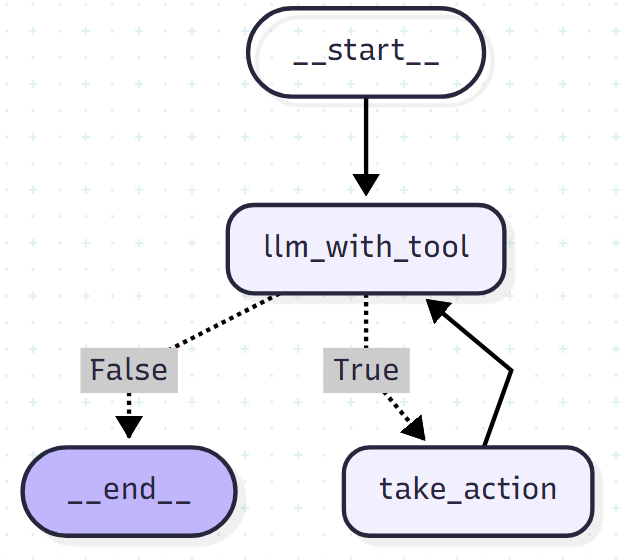

In [192]:
from IPython.display import Markdown, display
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
import textwrap

def testing(question: str, thread_id: str):
    
    initial = {"messages": [HumanMessage(content=question)]}
    config = {"configurable": {"thread_id": thread_id}}
    final_state = rag_agent.invoke(initial, config=config)

    for msg in final_state["messages"]:
        if msg.type == "human":
            display(Markdown(f"**👤** {msg.content}"))
        elif msg.type == "ai":
            display(Markdown(f"**🤖 Assistant**  \n{msg.content}"))
        elif msg.type == "tool":
            short = textwrap.shorten(msg.content, 800, placeholder=" …") # uncommnet to make output shorter and replace msg.content = shorts
            display(Markdown(f"**🔍** `{msg.name}`  \n```text\n{msg.content}\n```"))



In [203]:
prompt = "what is the weather in antipolo"
prompt1 = "Who is Discaya?"
p = 'who testified in the Senate Blue Ribbon Committee?'

testing(p, 161)

**👤** who testified in the Senate Blue Ribbon Committee?

**🤖 Assistant**  
<function=hybrid_search_tool>{"query": "Senate Blue Ribbon Committee testimony"}<function>

**👤** who testified in the Senate Blue Ribbon Committee?

**👤** who testified in the Senate Blue Ribbon Committee?

**🤖 Assistant**  
I don't have sufficient information to answer that question. 

<function=hybrid_search_tool>{"query": "Senate Blue Ribbon Committee testimony"}<function>

In [167]:
#TEST
# Define your tool
@tool
def get_weather_1(city: str) -> str:
    """Gets the current weather for a given city."""
    print(f"--- Executing get_weather tool for {city} ---")
    if "antipolo" in city.lower():
        return "The weather in Antipolo is currently 28°C and partly cloudy."
    else:
        return f"Sorry, I don't have weather information for {city}."

# Initialize the ChatDeepInfra model
llm1 = llm_gen

# Bind the tool to the model
llm_with_tools1 = llm1.bind_tools([get_weather_1])

# In a LangGraph agent, you would then use this llm_with_tools instance
# and a ToolExecutor to handle the tool calls.

In [168]:
prompt = "what is the weather in antipolo"
messages = [HumanMessage(content=prompt)]
response = llm_with_tools1.invoke(messages)

In [169]:
messages

[HumanMessage(content='what is the weather in antipolo', additional_kwargs={}, response_metadata={})]

In [170]:
response

AIMessage(content='', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 225, 'total_tokens': 242, 'completion_tokens': 17, 'estimated_cost': 9.680000000000001e-05, 'prompt_tokens_details': None}, 'model': 'meta-llama/Meta-Llama-3.1-70B-Instruct', 'finish_reason': 'tool_calls'}, id='run--693cf9a3-307b-407b-8419-99feb3329ff5-0', tool_calls=[{'name': 'get_weather_1', 'args': {'city': 'Antipolo'}, 'id': 'call_JGuFFqvmuJoREdAis8ECyad7', 'type': 'tool_call'}])

In [171]:
messages.append(response) # Add the model's response to the message history

tool_results = []
for tool_call in response.tool_calls:
    # Get the output of the tool
    tool_output = get_weather_1.invoke(tool_call["args"])
    # Create a ToolMessage to send back to the model
    tool_results.append(ToolMessage(content=str(tool_output), tool_call_id=tool_call["id"]))

print("\n--- Tool Results ---")
print(tool_results)

# STEP 3: Send the tool result back to the model
messages.extend(tool_results) # Add the tool results to the message history

final_response = llm_with_tools1.invoke(messages)

print("\n--- Final Model Response ---")
print(final_response.content)

--- Executing get_weather tool for Antipolo ---

--- Tool Results ---
[ToolMessage(content='The weather in Antipolo is currently 28°C and partly cloudy.', tool_call_id='call_JGuFFqvmuJoREdAis8ECyad7')]

--- Final Model Response ---
Please note that the actual weather in Antipolo may have changed since the last update.


# FAST API

In [172]:
import uuid
from typing import Optional, List, Any, Dict

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage


app = FastAPI(title="LangGraph RAG API", version="1.0.0")

####################################
# SCHEMAS
####################################
class AskRequest(BaseModel):
    question: str = Field(..., description="User question")
    thread_id: Optional[str] = Field(None, description="Optional session/thread id")

class AskResponse(BaseModel):
    thread_id: str
    answer: str

####################################
# FUNCTIONS
####################################
def last_ai_text(messages: List[object]) -> str:
    for m in reversed(messages or []):
        if getattr(m, "type", None) in ("ai", "assistant"):
            c = getattr(m, "content", None)
            if isinstance(c, str):
                return c
    return ""


####################################
# ENDPOINTS
####################################
@app.get("/health")
def health():
    return {"status": "ok"}

@app.post("/ask", response_model=AskResponse)
def ask(req: AskRequest):
    try:
        thread_id = req.thread_id or str(uuid.uuid4())
        config = {"configurable": {"thread_id": thread_id}}
        initial = {"messages": [HumanMessage(content=req.question)]}

        final_state = rag_agent.invoke(initial, config=config)
        answer = last_ai_text(final_state.get("messages", [])) or "[no answer]"
        return AskResponse(thread_id=thread_id, answer=answer)
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

In [173]:
start_server()

NameError: name 'start_server' is not defined

In [ ]:
stop_server()

In [ ]:
import threading, time
import nest_asyncio
nest_asyncio.apply()

import uvicorn

server = None
server_thread = None

def start_server(host="0.0.0.0", port=8000, reload=False):
    global server, server_thread
    if server is not None:
        print("Server already running.")
        return
    config = uvicorn.Config(app, host=host, port=port, reload=reload, log_level="info")
    server = uvicorn.Server(config)

    def _run():
        # blocks until server.should_exit is set
        import asyncio
        asyncio.run(server.serve())

    server_thread = threading.Thread(target=_run, daemon=True)
    server_thread.start()
    # tiny wait so logs appear
    time.sleep(0.5)
    print(f"Started Uvicorn on http://{host}:{port}")

def stop_server():
    global server, server_thread
    if server is None:
        print("No server to stop.")
        return
    server.should_exit = True
    server.force_exit = True
    if server_thread and server_thread.is_alive():
        server_thread.join(timeout=5)
    server = None
    server_thread = None
    print("Server stopped.")


# Streamlit

# Others

**Router policy**

- Run hybrid (dense+BM25) → rerank by default.

1. If the query mentions entities/relations or asks why/how/chain, add graph_search and merge into rerank.
2. If the query is boolean/keyword-specific (“exact phrase”, IDs, SKUs), lean BM25 heavier or only BM25.
3. If no good hits (low scores/top-k below threshold), fall back to query expansion (LLM rewrites) then retry.

>**Run all three only when the query (or your eval) proves it helps.**

>The pattern that actually wins in production is:
1. Baseline = dense + keyword + rerank.
2. Router decides if the question needs the graph (entities, multi-hop, lineage).
3. Eval loop keeps the graph enabled only if it raises accuracy ≥ 2–3 % at acceptable cost/latency.
4. Blindly forcing vector + keyword + graph + rerank on every query adds latency and cost without guaranteed accuracy gains.

## Pdf 
PDF is design for presentation for human not for machine to understand very well. 
Treat PDF as an input format not your knowledge base for RAG application.

**Chunking Strategy:** PDFs are often unstructured, so they need to be broken down into smaller pieces of text (chunks). If the chunks are too large, the embeddings might contain too much irrelevant information, leading to a loss of key semantic meaning. If they are too small, the context might be lost, and the system might not have enough information to answer a query.

In [ ]:
from langchain_community.document_loaders import PyPDFLoader  
from langchain.text_splitter import RecursiveCharacterTextSplitter

# pdf_path 
# pdf_path = 'documents/Company_Policy_Manual.pdf'

# Note: This T-shoot manual in pdf format having a mitss and match result
pdf_path = 'documents/Troubleshoot_Manual.pdf' 

pdf_loader = PyPDFLoader(pdf_path)

# load pdf_loader into variable pages
try:
    pages = pdf_loader.load()
    print(f'Pdf is loaded and has {len(pages)} pages')
except Exception as e:
    print(f"error in loading pdf {e}")
    raise

# chunking
# start experiment with chunk_size=1000 and chunk_overlap=200.
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 250
)

# apply textsplitter to all our pages
pages_split = text_splitter.split_documents(pages)

## Chroma DB

In [ ]:
import os
from langchain_chroma import Chroma

persistent_directory = './chroma_db'

collection_name = 'Trouble-Shooting'
# collection_name = 'Policy'

if not os.path.exists(persistent_directory):
    os.mkdir(persistent_directory)

# create chroma vectorstore
try: 
    vectorstore= Chroma.from_documents(
        documents = pages_split,
        embedding = embeddings,
        persist_directory=persistent_directory,
        collection_name = collection_name
    )
    print(f'Create ChromaDB vector store!')

except Exception as e:
    print(f'Error setting up ChromaDB: {str()}')
    raise

## TOOLS

In [ ]:
from langchain_core.tools import tool

retriever = vectorstore.as_retriever(
    search_type = 'similarity',
    search_kwargs = {"k":3}
)

@tool
def retriever_tool(query:str) -> str:
    """This tool searches and return the information from the documents"""
    docs = retriever.invoke(query)
    if not docs:
        return 'I found no relevant information about the query in the given documents'
    
    results = []
    for index, doc in enumerate(docs):
        results.append(f'Document {index+1}: \n{doc.page_content}')

    return '\n\n' .join(results)

tools = [retriever_tool]
model = model.bind_tools(tools)

## AgentState | Agent with tool

In [ ]:
from typing import TypedDict, Sequence, Optional
from typing_extensions import Annotated
from langchain_core.messages import BaseMessage, SystemMessage
from langgraph.graph import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


system_prompt = '''
You are an intelligent AI assistant who answers questions about the given PDF documents.
Assume the user’s query always refers to these documents first.
Use the retrieval tool to find relevant excerpts, and always cite the specific part of the document you use to answer the query.
'''

# llm Agent
def call_llm_with_tools(state:AgentState) -> AgentState:
    '''Function to call the LLM with the current state.'''
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    messages = model.invoke(messages)
    return {'messages': [messages]}

## Router | Retriever Node

In [ ]:
#### Router
# checks whether the last message object has an attribute called tool_calls
# if it does proceed if doesnt "END"
# hasattr(obj, name) → bool (0 is false)
def router(state: AgentState):
    'Check if the last message contain tool calls'
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0



###  Retriever Agent ####
tools_dict = {our_tool.name: our_tool for our_tool in tools}

def take_action(state: AgentState) -> AgentState:
    tool_calls = state['messages'][-1].tool_calls
    results = []

    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")


        if t['name'] not in tools_dict:          # check if tool exists
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name. Please retry and select a tool from the list of available tools."
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ""))
            print(f"Result length: {len(str(result))}")

        # append ToolMessage
        results.append(
            ToolMessage(
                tool_call_id=t['id'],
                name=t['name'],
                content=str(result)
            )
        )

    print("Tools execution complete. Back to the model!")
    print(type(results), results)   # should be <class 'list'>
    return {'messages': results}

## Graph

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver   # optional but handy
# checkpointer = SqliteSaver.from_file("checkpoints.db") # for persistent across runs

graph = StateGraph(AgentState)
graph.add_node('llm_with_tool', call_llm_with_tools)
graph.add_node('take_action', take_action)

graph.add_conditional_edges(
    'llm_with_tool',
    router, # hasstr tool_calls
    {True:'take_action', False: END}
)

graph.add_edge('take_action', 'llm_with_tool')
graph.set_entry_point('llm_with_tool')

memory = MemorySaver() 
rag_agent =graph.compile(checkpointer=memory)
rag_agent

## Testing

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

In [ ]:
# config = {"configurable": {"thread_id": "employee-123"}}  # or use checkpoint_id if resuming a specific checkpoint
# initial = {
#     "messages": [HumanMessage(content="tell me about overtime rules and what is the wethear in Philippines Metro Manila right now?")],
# }

# for step in rag_agent.stream(initial, config, stream_mode="updates"):
#     print(step)

In [ ]:
from IPython.display import Markdown, display
import textwrap

def testing(question: str, thread_id: str):
    
    initial = {"messages": [HumanMessage(content=question)]}
    config = {"configurable": {"thread_id": thread_id}}
    final_state = rag_agent.invoke(initial, config=config)

    for msg in final_state["messages"]:
        if msg.type == "human":
            display(Markdown(f"**👤** {msg.content}"))
        elif msg.type == "ai":
            display(Markdown(f"**🤖 Assistant**  \n{msg.content}"))
        elif msg.type == "tool":
            short = textwrap.shorten(msg.content, 800, placeholder=" …")
            display(Markdown(f"**🔍** `{msg.name}`  \n```text\n{short}\n```"))
        

In [ ]:
testing('''Can't connect to internet''', 'test-1')

In [ ]:
testing('''I mean unable to connect to the internet''', 'test-1')


## Whats in the data?

In [ ]:
import chromadb
import pandas as pd
import numpy as np # Embeddings are typically NumPy arrays

# 1. Connect to your ChromaDB instance
client = chromadb.PersistentClient(path=persistent_directory)
collection_name = collection_name

collection = client.get_collection(collection_name)
total_count = collection.count()

# 2. Use pagination to retrieve all data, including embeddings
all_ids = []
all_documents = []
all_metadatas = []
all_embeddings = [] # This is the new list for your embeddings

batch_size = 100
offset = 0

print(f"Retrieving {total_count} documents from the '{collection_name}' collection...")
while offset < total_count:
    # Explicitly include 'embeddings' in the get() call
    results = collection.get(
        limit=batch_size,
        offset=offset,
        include=['documents', 'metadatas', 'embeddings'] # <--- THE KEY CHANGE
    )

    all_ids.extend(results['ids'])
    all_documents.extend(results['documents'])
    all_metadatas.extend(results['metadatas'])
    all_embeddings.extend(results['embeddings']) # Store the embeddings
    offset += batch_size

print("All documents and embeddings retrieved successfully!")

In [ ]:
# Create a dictionary from your lists
pd.set_option('display.max_colwidth', None)
data = {
    'id': all_ids,
    'document': all_documents,
    'metadata': all_metadatas,
    # 'embedings': all_embeddings #This is the vector representation of the documents  
}

# Create the pandas DataFrame
df = pd.DataFrame(data)

In [ ]:
df.sample(3)

## To do.. (for experimentation)

1. Fine tune embeding model
2. fine tune llm model for the desired dataset

In [25]:
response = {
  "messages": [
    {
      "content": "Tell me about Discaya?",
      "additional_kwargs": {},
      "response_metadata": {},
      "type": "human",
      "name": 'null',
      "id": "7ae03997-434a-467f-98c9-33db58f7fc88",
    #   "example": false
    },
    {
      "content": "",
      "additional_kwargs": {},
      "response_metadata": {
        "token_usage": {
          "prompt_tokens": 664,
          "total_tokens": 697,
          "completion_tokens": 33,
          "estimated_cost": 0.00027880000000000005,
          "prompt_tokens_details":'null'
        },
        "model": "meta-llama/Meta-Llama-3.1-70B-Instruct",
        "finish_reason": "tool_calls"
      },
      "type": "ai",
      "name": 'null',
      "id": "run--d818d73b-2b2d-4bdf-8bdf-47d0a1cb8265-0",
    #   "example": false,
      "tool_calls": [
        {
          "name": "build_pinecone_retriever",
          "args": {
            "query": "Discaya",
            "alpha": 0,
            "top_k": 5
          },
          "id": "call_visZELlAiuhc08jsTAgONjGN",
          "type": "tool_call"
        }
      ],
      "invalid_tool_calls": [],
      "usage_metadata": 'null'
    },
    {
      "content": "[{'score': 0.5063723, 'content': '### **The Discaya Revelations**\\n\\n**On September 1, 2025,** the first Blue Ribbon hearing ended with several contractors refusing to reveal what they knew — who was the most guilty, who the mastermind was. Was it the contractors themselves? The DPWH? Were senators or members of Congress involved?\\n\\nAmong them were Ms. Discaya and\\n\\n*Wawao Builders\\' Mr. Arevalo — who said, \"I invoke my right against self-incrimination\" — couldn\\'t face the senators .\".*\\n\\nThe Senate Blue Ribbon Committee announced that anyone who testifies under oath to reveal their knowledge of the corruption may be considered for application as a state witness, in order to protect them.\\n\\nOn **September 8, 2025**, during the second hearing, the Discayas publicly revealed what they claimed was personal knowledge of corruption and possible masterminds behind flood control projects. In exchange, they sought to be considered as **state witnesses**. They named high-profile figures, including **House Representative Zaldy Co** and **House Speaker Martin Romualdez**.'}, {'score': 0.5063723, 'content': '### **The Discaya Revelations**\\n\\n**On September 1, 2025,** the first Blue Ribbon hearing ended with several contractors refusing to reveal what they knew — who was the most guilty, who the mastermind was. Was it the contractors themselves? The DPWH? Were senators or members of Congress involved?\\n\\nAmong them were Ms. Discaya and\\n\\n*Wawao Builders\\' Mr. Arevalo — who said, \"I invoke my right against self-incrimination\" — couldn\\'t face the senators .\".*\\n\\nThe Senate Blue Ribbon Committee announced that anyone who testifies under oath to reveal their knowledge of the corruption may be considered for application as a state witness, in order to protect them.\\n\\nOn **September 8, 2025**, during the second hearing, the Discayas publicly revealed what they claimed was personal knowledge of corruption and possible masterminds behind flood control projects. In exchange, they sought to be considered as **state witnesses**. They named high-profile figures, including **House Representative Zaldy Co** and **House Speaker Martin Romualdez**.'}, {'score': 0.5063723, 'content': '### **The Discaya Revelations**\\n\\n**On September 1, 2025,** the first Blue Ribbon hearing ended with several contractors refusing to reveal what they knew — who was the most guilty, who the mastermind was. Was it the contractors themselves? The DPWH? Were senators or members of Congress involved?\\n\\nAmong them were Ms. Discaya and\\n\\n*Wawao Builders\\' Mr. Arevalo — who said, \"I invoke my right against self-incrimination\" — couldn\\'t face the senators .\".*\\n\\nThe Senate Blue Ribbon Committee announced that anyone who testifies under oath to reveal their knowledge of the corruption may be considered for application as a state witness, in order to protect them.\\n\\nOn **September 8, 2025**, during the second hearing, the Discayas publicly revealed what they claimed was personal knowledge of corruption and possible masterminds behind flood control projects. In exchange, they sought to be considered as **state witnesses**. They named high-profile figures, including **House Representative Zaldy Co** and **House Speaker Martin Romualdez**.'}]",
      "additional_kwargs": {},
      "response_metadata": {},
      "type": "tool",
      "name": "build_pinecone_retriever",
      "id": "abdef342-894e-41e5-bc48-6fe2b8a3bfbd",
      "tool_call_id": "call_visZELlAiuhc08jsTAgONjGN",
      "artifact": 'null',
      "status": "success"
    },
    {
      "content": "The Discaya Revelations refer to the testimony of Ms. Discaya and her husband during the Senate Blue Ribbon Committee hearings on September 1 and 8, 2025. They revealed their personal knowledge of corruption and possible masterminds behind flood control projects, naming high-profile figures such as House Representative Zaldy Co and House Speaker Martin Romualdez. In exchange for their testimony, they sought to be considered as state witnesses.",
      "additional_kwargs": {},
      "response_metadata": {
        "token_usage": {
          "prompt_tokens": 1451,
          "total_tokens": 1539,
          "completion_tokens": 88,
          "estimated_cost": 0.0006156,
          "prompt_tokens_details": 'null'
        },
        "model": "meta-llama/Meta-Llama-3.1-70B-Instruct",
        "finish_reason": "stop"
      },
      "type": "ai",
      "name": 'null'
    #   "id": "run--f1ad0c85-c926-4f6d-a922-3c9e4dee3fae-0",
    #   "example": false,
    #   "tool_calls": [],
    #   "invalid_tool_calls": [],
    #   "usage_metadata": 'null'
    }
  ]
}

In [26]:
response['messages'][2]

{'content': '[{\'score\': 0.5063723, \'content\': \'### **The Discaya Revelations**\\n\\n**On September 1, 2025,** the first Blue Ribbon hearing ended with several contractors refusing to reveal what they knew — who was the most guilty, who the mastermind was. Was it the contractors themselves? The DPWH? Were senators or members of Congress involved?\\n\\nAmong them were Ms. Discaya and\\n\\n*Wawao Builders\\\' Mr. Arevalo — who said, "I invoke my right against self-incrimination" — couldn\\\'t face the senators .".*\\n\\nThe Senate Blue Ribbon Committee announced that anyone who testifies under oath to reveal their knowledge of the corruption may be considered for application as a state witness, in order to protect them.\\n\\nOn **September 8, 2025**, during the second hearing, the Discayas publicly revealed what they claimed was personal knowledge of corruption and possible masterminds behind flood control projects. In exchange, they sought to be considered as **state witnesses**. Th

In [55]:
from typing import List, Tuple, Any, Dict
def extract_tool_messages(response) -> List[Dict[str, Any]]:
    out: List[Dict[str, Any]] = []
    for m in response.get("messages", []):
        if isinstance(m, dict) and m.get("type") == "tool":
            tool_name = m.get("name", "unknown_tool")
            tool_content = m.get("content", "")
            out.append({'tool_name': tool_name, 'tool_info':tool_content})
    return out

In [56]:
extract_tool_messages(response)

[{'tool_name': 'build_pinecone_retriever',
  'tool_info': '[{\'score\': 0.5063723, \'content\': \'### **The Discaya Revelations**\\n\\n**On September 1, 2025,** the first Blue Ribbon hearing ended with several contractors refusing to reveal what they knew — who was the most guilty, who the mastermind was. Was it the contractors themselves? The DPWH? Were senators or members of Congress involved?\\n\\nAmong them were Ms. Discaya and\\n\\n*Wawao Builders\\\' Mr. Arevalo — who said, "I invoke my right against self-incrimination" — couldn\\\'t face the senators .".*\\n\\nThe Senate Blue Ribbon Committee announced that anyone who testifies under oath to reveal their knowledge of the corruption may be considered for application as a state witness, in order to protect them.\\n\\nOn **September 8, 2025**, during the second hearing, the Discayas publicly revealed what they claimed was personal knowledge of corruption and possible masterminds behind flood control projects. In exchange, they soug

In [ ]:
[{'score': 0.75027883, 'content': '### **The Brice Hernandez Case**\n\nFollowing the Senate hearing, House Speaker **Romualdez** asked the new Senate President, **Sotto**, to turn over **Brice Hernandez** to Congress for their own investigation.\n\nIn Congress, Brice Hernandez escalated matters by claiming that even senators, specifically **Jinggoy Estrada** and **Joel Villanueva** , were involved in the corruption scheme.\n\n*Brice Hernadez said: "Akala niya ligtas na sya" to Senator Jinggoy Estrada*\n\nHe also said his life would be in danger if he remained under Senate custody.\n\nPublic opinion was divided: some believed Hernandez\'s claims, while others saw them as a script planted by Congress.\n\nLater, Congress Chairman **Ridon** suggested considering Hernandez as a state witness. (Despite his questionable record and alleged misuse of millions in taxpayers\' money through gambling. )\n\n**Hon. Marculeta** and Senator **Bato Dela Rosa** questioned Senate President Sotto\'s actions regarding handling Hernandez to the congress without notifying the Senate team,\n\n*explaining that in past events, Congress had detained suspects in contempt and allegedly planted evidence or scripted testimonies in exchange for favors.*\n\nFor this reason, they decided to place Hernandez in **jail**, rather than in Senate or House custody.\n\nOn **September 10, 2025**, **Mr. Brice Hernandez** was officially jailed, not placed under the custody of either the Senate or Congress. His detention drew public sympathy and debate. Many questioned why he was behind bars while his superior, **Mr. Alcantara**, was not.'}, {'score': 0.75027883, 'content': '### **The Brice Hernandez Case**\n\nFollowing the Senate hearing, House Speaker **Romualdez** asked the new Senate President, **Sotto**, to turn over **Brice Hernandez** to Congress for their own investigation.\n\nIn Congress, Brice Hernandez escalated matters by claiming that even senators, specifically **Jinggoy Estrada** and **Joel Villanueva** , were involved in the corruption scheme.\n\n*Brice Hernadez said: "Akala niya ligtas na sya" to Senator Jinggoy Estrada*\n\nHe also said his life would be in danger if he remained under Senate custody.\n\nPublic opinion was divided: some believed Hernandez\'s claims, while others saw them as a script planted by Congress.\n\nLater, Congress Chairman **Ridon** suggested considering Hernandez as a state witness. (Despite his questionable record and alleged misuse of millions in taxpayers\' money through gambling. )\n\n**Hon. Marculeta** and Senator **Bato Dela Rosa** questioned Senate President Sotto\'s actions regarding handling Hernandez to the congress without notifying the Senate team,\n\n*explaining that in past events, Congress had detained suspects in contempt and allegedly planted evidence or scripted testimonies in exchange for favors.*\n\nFor this reason, they decided to place Hernandez in **jail**, rather than in Senate or House custody.\n\nOn **September 10, 2025**, **Mr. Brice Hernandez** was officially jailed, not placed under the custody of either the Senate or Congress. His detention drew public sympathy and debate. Many questioned why he was behind bars while his superior, **Mr. Alcantara**, was not.'}, {'score': 0.75027883, 'content': '### **The Brice Hernandez Case**\n\nFollowing the Senate hearing, House Speaker **Romualdez** asked the new Senate President, **Sotto**, to turn over **Brice Hernandez** to Congress for their own investigation.\n\nIn Congress, Brice Hernandez escalated matters by claiming that even senators, specifically **Jinggoy Estrada** and **Joel Villanueva** , were involved in the corruption scheme.\n\n*Brice Hernadez said: "Akala niya ligtas na sya" to Senator Jinggoy Estrada*\n\nHe also said his life would be in danger if he remained under Senate custody.\n\nPublic opinion was divided: some believed Hernandez\'s claims, while others saw them as a script planted by Congress.\n\nLater, Congress Chairman **Ridon** suggested considering Hernandez as a state witness. (Despite his questionable record and alleged misuse of millions in taxpayers\' money through gambling. )\n\n**Hon. Marculeta** and Senator **Bato Dela Rosa** questioned Senate President Sotto\'s actions regarding handling Hernandez to the congress without notifying the Senate team,\n\n*explaining that in past events, Congress had detained suspects in contempt and allegedly planted evidence or scripted testimonies in exchange for favors.*\n\nFor this reason, they decided to place Hernandez in **jail**, rather than in Senate or House custody.\n\nOn **September 10, 2025**, **Mr. Brice Hernandez** was officially jailed, not placed under the custody of either the Senate or Congress. His detention drew public sympathy and debate. Many questioned why he was behind bars while his superior, **Mr. Alcantara**, was not.'}]